In [1]:
using Flux, Statistics
using Flux: crossentropy, throttle, logitcrossentropy
using Base.Iterators: repeated, partition, flatten
using DelimitedFiles
using LinearAlgebra
using RDatasets
using GLM
using BSON: @save, @load
using Random
using Base.Threads 
using Plots

┌ Warning: The NVIDIA driver on this system only supports up to CUDA 11.0.0.
│ For performance reasons, it is recommended to upgrade to a driver that supports CUDA 11.2 or higher.
└ @ CUDA /home/jupyter-nrmeskell/.julia/packages/CUDA/mVgLI/src/initialization.jl:42


In [2]:
function getEdepGateBarA0(number, angle)
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    angle = lpad(angle,3,"0")
    fileName = filter(x->occursin(string("A", angle), x), readdir(folder))[number]
    filePath = string(folder, fileName)
    return Int.(round.(reshape(readdlm(filePath)[4:67, 2], (8,8))))
end

getEdepGateBarA0 (generic function with 1 method)

In [3]:
#getEdepGateBarA0(1, 0)

In [4]:
function getEdepGateBarA90(number, angle)
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    angle90 = lpad(angle+90, 3, "0")
    fileName90 = filter(x->occursin(string("A", angle90), x), readdir(folder))[number]
    filePath90 = string(folder, fileName90)
    return return Int.(round.(reshape(readdlm(filePath90)[4:67,2], (8,8))))
end

getEdepGateBarA90 (generic function with 1 method)

In [5]:
#getEdepGateBarA90(1, 40)

In [6]:
function getEdepGateGrid(number, angle)
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/cubes/"
    angle = lpad(angle, 3, "0")
    fileName = filter(x->occursin(string("A", angle), x), readdir(folder))[number]
    filePath = string(folder, fileName)
    return Int.(round.(readdlm(filePath)[4:515,2]))
end

getEdepGateGrid (generic function with 1 method)

In [7]:
#getEdepGateGrid(1, 45)

dosimeter/gate_data/bars/W05__H05__A000_bars_extracted.txt

In [8]:
function getEdepOhioBarA0(number)
    folder = "/home/jupyter-nrmeskell/dosimeter/ohio_data/extracted_data/"
    fileName = filter(x->occursin(r"R...txt", x), readdir(folder))[number]
    filePath = string(folder,fileName)
    return Int.(round.(reshape(readdlm(filePath)[4:67,2], (8,8))))
end

getEdepOhioBarA0 (generic function with 1 method)

In [9]:
#getEdepOhioBarA0(1)

In [10]:
function getEdepOhioBarA90(number)
    folder = "/home/jupyter-nrmeskell/dosimeter/ohio_data/extracted_data/"
    fileName = filter(x->occursin(r"R.._r.txt", x), readdir(folder))[number]
    filePath = string(folder,fileName)
    return Int.(round.(reshape(readdlm(filePath)[4:67,2], (8,8))))
end

getEdepOhioBarA90 (generic function with 1 method)

In [11]:
#getEdepOhioBarA90(1)

In [12]:
function normalize(inputArray)
    min = minimum(inputArray)
    inputArray = (inputArray.-(min))
    max = maximum(inputArray)/1023
    inputArray = (inputArray./max).+1
    return Int.(round.(inputArray))
end

normalize (generic function with 1 method)

In [13]:
#normalize(getEdepOhioBarA90(1))

In [14]:
#normalize(getEdepOhioBarA0(1))

In [15]:
function makeTrainingData()
    numRuns = 15
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    trainingSize = size(filter(x->occursin("A000", x), readdir(folder)))[1]
    trainingArray = Array{Int64}(undef, 8, 8, 2, trainingSize*numRuns)
    
    for i = 1:trainingSize
        for r = 1:numRuns
            trainingArray[:, :, 1, (i-1)*numRuns + r] = getEdepGateBarA0(i,  (r-1)*15)
            trainingArray[:, :, 2, (i-1)*numRuns + r] = getEdepGateBarA90(i,  (r-1)*15)
        end
    end
    
    return trainingArray
end

makeTrainingData (generic function with 1 method)

In [16]:
size(filter(x->occursin("E02__W05__H05", x), readdir("/home/jupyter-nrmeskell/dosimeter/gate_data/bars/")))[1]

24

In [17]:
size(filter(x->occursin("A000", x), readdir("/home/jupyter-nrmeskell/dosimeter/gate_data/bars/")))[1]

500

In [18]:
function makeValidationData()
    numRuns = 18-15
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    trainingSize = size(filter(x->occursin("A000", x), readdir(folder)))[1]
    trainingArray = Array{Int64}(undef, 8, 8, 2, trainingSize*numRuns)
    for i = 1:trainingSize
        for r = 1:numRuns
            trainingArray[:, :, 1, (i-1)*numRuns + r] = getEdepGateBarA0(i, (r-1)*15 + numRuns*15)
            trainingArray[:, :, 2, (i-1)*numRuns + r] = getEdepGateBarA90(i, (r-1)*15 + numRuns*15)
        end
    end
    return trainingArray
end

makeValidationData (generic function with 1 method)

In [19]:
getEdepGateBarA0(1, (1-1)*15 + 15*15)

8×8 Matrix{Int64}:
 1  2   5  391  331  27   1   2
 2  3   2  537  408  18   2   1
 0  2  11  430  461   4   1   0
 0  2   4  341  550   3   2   1
 1  1   4  487  360   6   1   0
 3  1   4  433  399   5   3   2
 3  1   3  365  363   2   5   0
 0  1  48  162  188  25  17  28

In [20]:
function makeTargetData()
    numRuns = 15
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/cubes/"
    trainingSize = size(filter(x->occursin("A000", x), readdir(folder)))[1]
    trainingArray = Array{Int64}(undef, 8*8*8, trainingSize*numRuns)
    for i = 1:trainingSize
        for r = 1:numRuns
            trainingArray[:, (i-1)*numRuns + r] = getEdepGateGrid(i, (r-1)*15)
        end
    end
    return trainingArray
end

makeTargetData (generic function with 1 method)

In [21]:
#makeTargetData()

In [22]:
function makeValTargetData()
    numRuns = 18-15
    folder = "/home/jupyter-nrmeskell/dosimeter/gate_data/cubes/"
    trainingSize = size(filter(x->occursin("A000", x), readdir(folder)))[1]
    trainingArray = Array{Int64}(undef, 8*8*8, trainingSize*numRuns)
    for i = 1:trainingSize
        for r = 1:numRuns
            trainingArray[:, (i-1)*numRuns + r] = getEdepGateGrid(i, (r-1)*15 + 225)
        end
    end
    return trainingArray
end

makeValTargetData (generic function with 1 method)

In [23]:
#makeValTargetData()

In [24]:
function makeInputData()
    folder = "/home/jupyter-nrmeskell/dosimeter/ohio_data/extracted_data/"
    trainingSize = size(filter(x->occursin("_r.txt", x), readdir(folder)))[1]
    trainingArray = Array{Int64}(undef, 8, 8, 2, trainingSize)
    
    for i = 1:trainingSize
        trainingArray[:,:,1,i] = getEdepOhioBarA0(i)
        trainingArray[:,:,2,i] = getEdepOhioBarA90(i)
    end
    return trainingArray
end

makeInputData (generic function with 1 method)

In [25]:
#makeInputData()

In [26]:
trainingArray = Float32.(makeTrainingData())

8×8×2×7500 Array{Float32, 4}:
[:, :, 1, 1] =
 2.0  3.0   2.0  379.0  382.0   3.0  0.0  0.0
 0.0  2.0   2.0  304.0  404.0   2.0  2.0  0.0
 2.0  2.0   5.0  320.0  341.0   2.0  0.0  0.0
 2.0  1.0  23.0  399.0  375.0   3.0  4.0  0.0
 1.0  3.0   6.0  369.0  484.0   7.0  1.0  0.0
 0.0  2.0   2.0  374.0  469.0   4.0  1.0  2.0
 1.0  1.0   3.0  253.0  421.0   4.0  1.0  2.0
 1.0  0.0  29.0  156.0  193.0  20.0  3.0  1.0

[:, :, 2, 1] =
 1.0   3.0  20.0  462.0  306.0   2.0  1.0  1.0
 0.0   5.0  21.0  517.0  295.0   2.0  1.0  1.0
 0.0   1.0   2.0  557.0  406.0   2.0  1.0  0.0
 1.0   0.0   5.0  497.0  517.0   2.0  4.0  1.0
 0.0   0.0  11.0  421.0  390.0   4.0  2.0  2.0
 1.0   2.0  35.0  334.0  254.0   2.0  3.0  0.0
 1.0   0.0  27.0  339.0  417.0  11.0  0.0  1.0
 1.0  31.0   1.0  218.0  239.0  20.0  0.0  1.0

[:, :, 1, 2] =
  0.0  4.0  13.0  300.0  300.0   6.0  2.0  2.0
  1.0  1.0   4.0  429.0  344.0   5.0  1.0  0.0
  2.0  3.0   3.0  398.0  331.0  20.0  4.0  2.0
  2.0  2.0  35.0  536.0  321.0   2.0  

In [27]:
targetArray = Float32.(makeTargetData())

512×7500 Matrix{Float32}:
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  …  0.0  0.0   0.0  0.0  0.0  2.0  0.0
 1.0  0.0  0.0  0.0  0.0  1.0  0.0     0.0  0.0  17.0  0.0  0.0  0.0  4.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0   0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0   0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0   0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  …  1.0  0.0   0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  1.0  0.0  0.0  0.0     1.0  0.0   0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  2.0  0.0  0.0     0.0  0.0   0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  1.0  22.0  0.0  0.0  1.0  0.0
 0.0  1.0  0.0  0.0  1.0  0.0  0.0     0.0  1.0  19.0  2.0  0.0  2.0  5.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  …  0.0  1.0  19.0  0.0  1.0  3.0  5.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0     1.0  0.0   0.0  0.0  0.0  2.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  18.0  0.0  0.0  1.0  1.0
 ⋮          

In [28]:
validationArray = Float32.(makeValidationData())

8×8×2×1500 Array{Float32, 4}:
[:, :, 1, 1] =
 1.0   1.0   3.0  308.0  400.0   3.0   2.0  3.0
 0.0   0.0   3.0  352.0  378.0   5.0   1.0  0.0
 1.0   2.0   2.0  341.0  432.0  13.0   1.0  2.0
 0.0   1.0   3.0  442.0  370.0   3.0   3.0  2.0
 2.0   2.0  42.0  418.0  363.0   5.0   3.0  0.0
 1.0   2.0   3.0  284.0  321.0  10.0   1.0  0.0
 1.0   1.0   2.0  237.0  296.0  18.0   2.0  2.0
 1.0  24.0  13.0  140.0  170.0   3.0  21.0  1.0

[:, :, 2, 1] =
  1.0  1.0   4.0  365.0  331.0   4.0   2.0   1.0
  3.0  2.0  14.0  413.0  280.0   5.0   2.0   1.0
  1.0  3.0   5.0  466.0  334.0   3.0   2.0   3.0
  1.0  2.0   4.0  393.0  411.0   4.0   1.0   0.0
  3.0  2.0   1.0  231.0  446.0  51.0   1.0   0.0
  1.0  1.0   4.0  384.0  456.0  55.0   2.0   0.0
  1.0  1.0   3.0  351.0  392.0   2.0   1.0   0.0
 15.0  1.0   1.0  177.0  184.0   4.0  24.0  14.0

[:, :, 1, 2] =
 0.0  1.0  14.0  342.0  359.0   3.0  0.0  1.0
 3.0  2.0   4.0  328.0  363.0   3.0  1.0  1.0
 1.0  2.0   1.0  250.0  359.0   6.0  3.0  2.0
 0.0  3.0

In [29]:
validationTargetArray = Float32.(makeValTargetData())

512×1500 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  …  3.0  0.0  0.0   0.0  0.0  0.0  20.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0   0.0  0.0  0.0   0.0
 1.0  1.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0   0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  1.0   1.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0   0.0  0.0  0.0   0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0   0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0   0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0   0.0  0.0  0.0   0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0     5.0  0.0  3.0   0.0  0.0  0.0  10.0
 0.0  1.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0   0.0  0.0  0.0   0.0
 1.0  1.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  3.0   0.0  0.0  0.0   0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  13.0  0.0  0.0   0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  32.0  0.0  0.0   9.0

In [30]:
inputArray = Float32.(makeInputData())

8×8×2×21 Array{Float32, 4}:
[:, :, 1, 1] =
 38484.0  42128.0  52850.0  126117.0  208366.0  54216.0  42413.0  38391.0
 39382.0  44555.0  47446.0  118228.0  285328.0  61556.0  41870.0  39128.0
 36595.0  39956.0  55851.0  189571.0  294911.0  57231.0  42411.0  38908.0
 38021.0  43502.0  45917.0  122588.0  483994.0  71271.0  40778.0  39157.0
 40115.0  46611.0  55757.0  176140.0  345909.0  74524.0  42913.0  39929.0
 39228.0  38664.0  58439.0  162217.0  244550.0  68536.0  43572.0  39139.0
 37466.0  37933.0  56898.0  131986.0  361086.0  60613.0  48624.0  37953.0
 35604.0  38155.0  43116.0   84692.0  184161.0  70698.0  43053.0  37902.0

[:, :, 2, 1] =
 19404.0  22059.0  44432.0  101296.0   77978.0  36257.0  21430.0  19332.0
 20006.0  24228.0  42568.0   87020.0  105097.0  53825.0  21343.0  20054.0
 17905.0  20826.0  56275.0  160868.0  105372.0  47073.0  21694.0  19664.0
 19379.0  23974.0  36643.0   91733.0  144345.0  65212.0  20635.0  20134.0
 20977.0  26756.0  56546.0  140444.0  126791.0  68834

In [31]:
function plotResults(m)
    image = rand((1: size(trainingArray)[2]))
    print(image)
    display(heatmap(reshape(Int64.(round.(m(validationArray)))[:,image], (8,8*8)), xlabel="Length/Height", ylabel="Width", title="GATE Prediction"))
    display(heatmap(reshape(validationTargetArray[:,image], (8,8*8)), xlabel="Length/Height", ylabel="Width", title="GATE Target"))
    display(heatmap(reshape(Int64.(round.(m(inputArray)))[:,1], (8,8*8)), xlabel="Length/Height", ylabel="Width", title="Ohio Data Prediction"))
end

plotResults (generic function with 1 method)

In [32]:
m = Chain(Conv((2,2), 2=>8, pad=(1,1), relu),
        Conv((2,2), 8=>16, pad=(1,1), relu),
        Dropout(0.05),

        x -> reshape(x, :, size(x,4)), 

        Dense(1600, 900),
        Dense(900, 8*8*8),
        x -> abs.(x))

Chain(Conv((2, 2), 2=>8, relu), Conv((2, 2), 8=>16, relu), Dropout(0.05), #25, Dense(1600, 900), Dense(900, 512), #26)

In [33]:
loss(x, y) = mean((m(x)-y).^2)
opt = ADAM(0.01)
dataset = (repeated((trainingArray, targetArray), 50))
evalcb = () -> @show (loss(trainingArray, targetArray)) 

CurrentR2 = r2(lm(@formula(A  ~ B), DataFrame(A=Float64.(m(trainingArray)[:,1]), B=targetArray[:,1])))
print("Training R2: ", CurrentR2, '\n')
CurrentVR2 = r2(lm(@formula(A  ~ B), DataFrame(A=Float64.(m(validationArray)[:,1]), B=validationTargetArray[:,1])))
print("Validation R2: ", CurrentVR2, '\n')

CVR2 = 0.0
i = 1

Training R2: 0.00016153370100224773
Validation R2: 0.0001667023836623427


1

loss(trainingArray, targetArray) = 506136.03f0
loss(trainingArray, targetArray) = 94558.96f0
loss(trainingArray, targetArray) = 43876.78f0
loss(trainingArray, targetArray) = 8100.415f0
loss(trainingArray, targetArray) = 9455.187f0
loss(trainingArray, targetArray) = 7192.711f0
loss(trainingArray, targetArray) = 6770.854f0
loss(trainingArray, targetArray) = 6401.5957f0
loss(trainingArray, targetArray) = 5828.574f0
loss(trainingArray, targetArray) = 4915.6895f0
Training R2: 0.4897298947339189
Validation R2: 0.5482207844304191

	

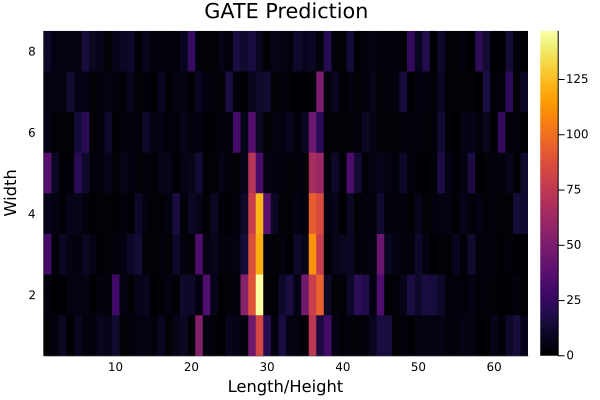

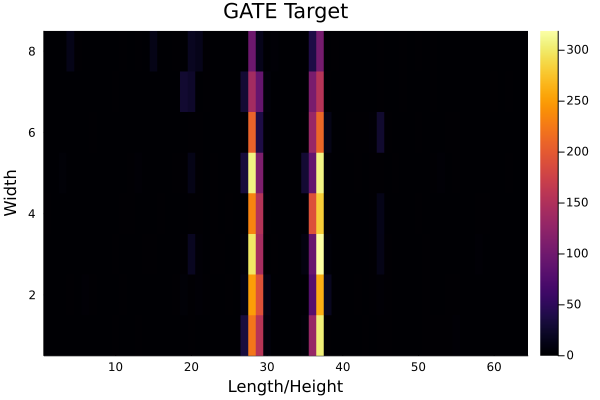

8

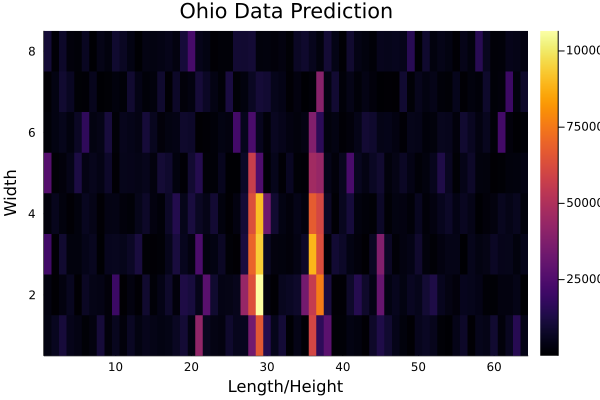

loss(trainingArray, targetArray) = 4307.263f0
loss(trainingArray, targetArray) = 3646.7654f0
loss(trainingArray, targetArray) = 3152.5857f0
loss(trainingArray, targetArray) = 2818.093f0
loss(trainingArray, targetArray) = 2497.0017f0
loss(trainingArray, targetArray) = 2269.4646f0
loss(trainingArray, targetArray) = 2149.6306f0
loss(trainingArray, targetArray) = 2032.5162f0
loss(trainingArray, targetArray) = 1951.0162f0


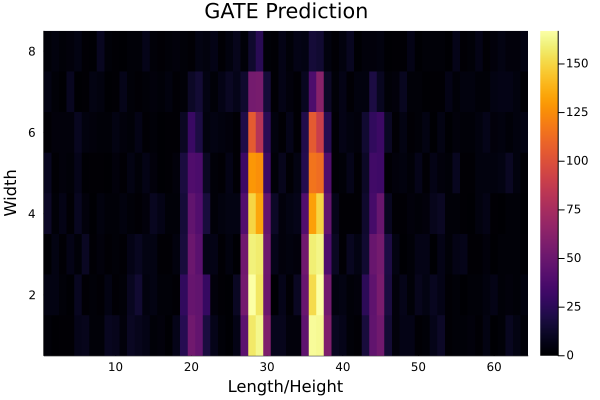

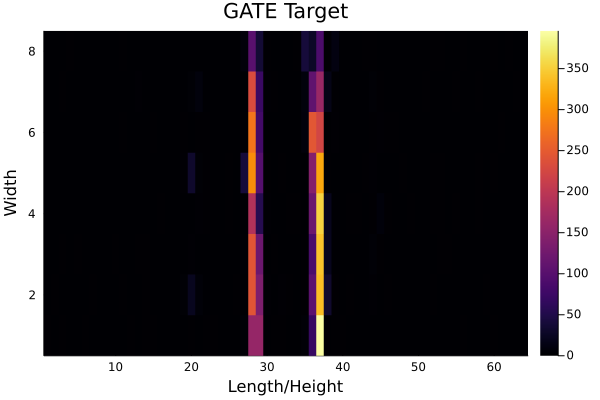

Training R2: 0.694963430342517
Validation R2: 0.7528736591346072

	7

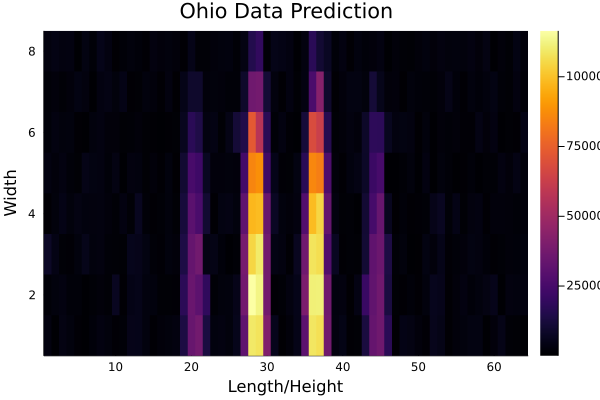

loss(trainingArray, targetArray) = 1911.7418f0
loss(trainingArray, targetArray) = 1869.9075f0
loss(trainingArray, targetArray) = 1830.344f0
loss(trainingArray, targetArray) = 1802.6565f0
loss(trainingArray, targetArray) = 1772.8263f0
loss(trainingArray, targetArray) = 1744.9592f0
loss(trainingArray, targetArray) = 1719.0365f0
loss(trainingArray, targetArray) = 1694.387f0
loss(trainingArray, targetArray) = 1670.4259f0


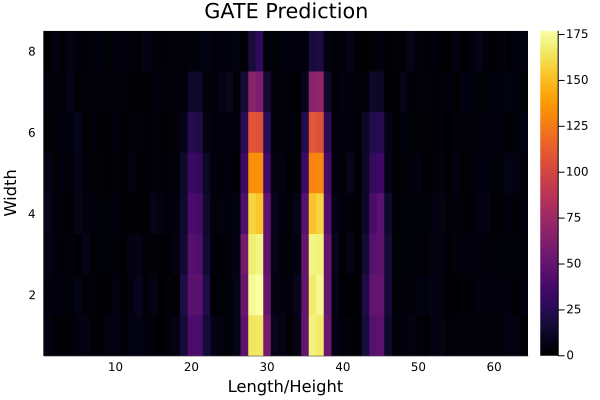

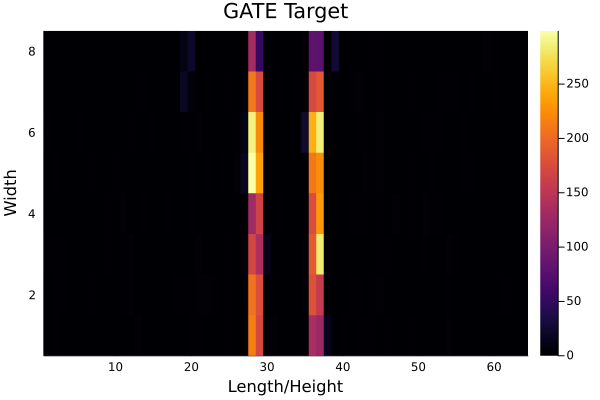

Training R2: 0.7445055096299573
Validation R2: 0.7953055712679067

	2

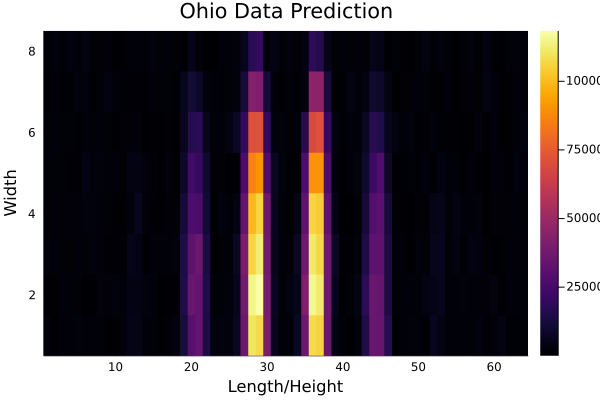

loss(trainingArray, targetArray) = 1654.5579f0
loss(trainingArray, targetArray) = 1630.9854f0
loss(trainingArray, targetArray) = 1611.539f0
loss(trainingArray, targetArray) = 1592.3157f0
loss(trainingArray, targetArray) = 1569.5593f0
loss(trainingArray, targetArray) = 1547.149f0
loss(trainingArray, targetArray) = 1528.8145f0
loss(trainingArray, targetArray) = 1507.3174f0
loss(trainingArray, targetArray) = 1486.5244f0


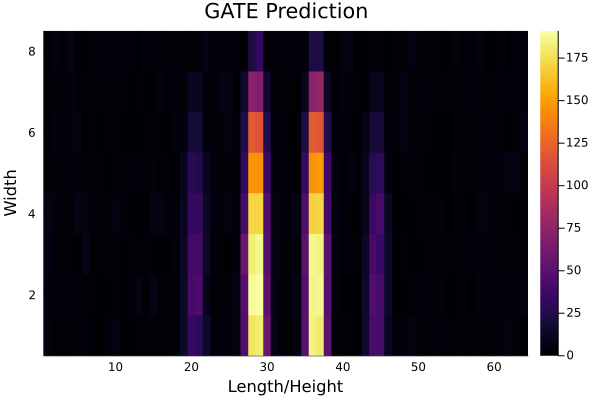

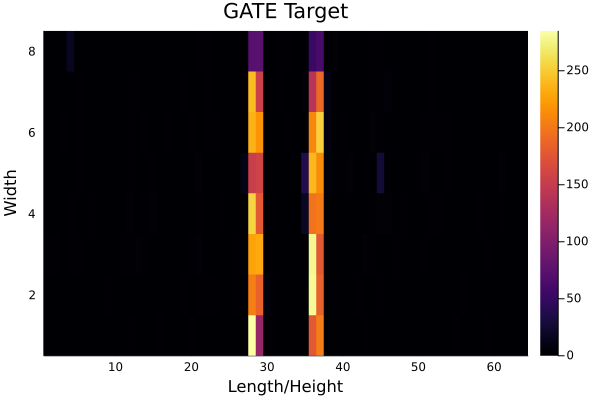

Training R2: 0.7775505039333714
Validation R2: 0.8251840952933517

	1

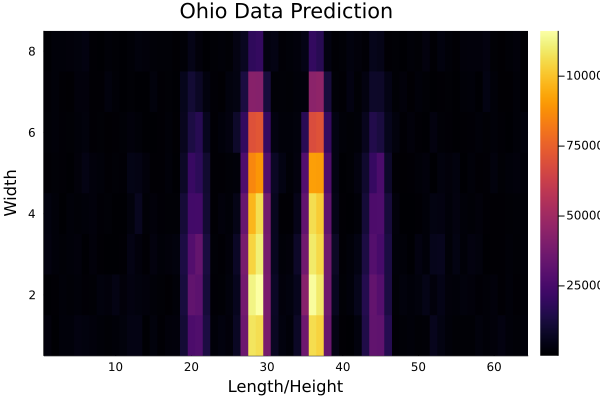

loss(trainingArray, targetArray) = 1469.7882f0
loss(trainingArray, targetArray) = 1450.3506f0
loss(trainingArray, targetArray) = 1431.653f0
loss(trainingArray, targetArray) = 1413.8123f0
loss(trainingArray, targetArray) = 1396.6732f0
loss(trainingArray, targetArray) = 1380.3256f0
loss(trainingArray, targetArray) = 1364.7382f0
loss(trainingArray, targetArray) = 1349.7207f0
loss(trainingArray, targetArray) = 1335.3339f0


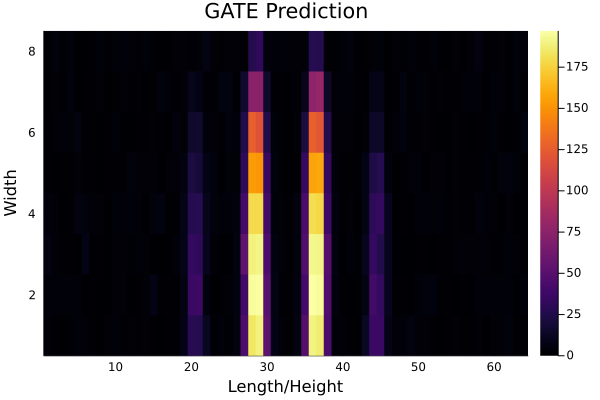

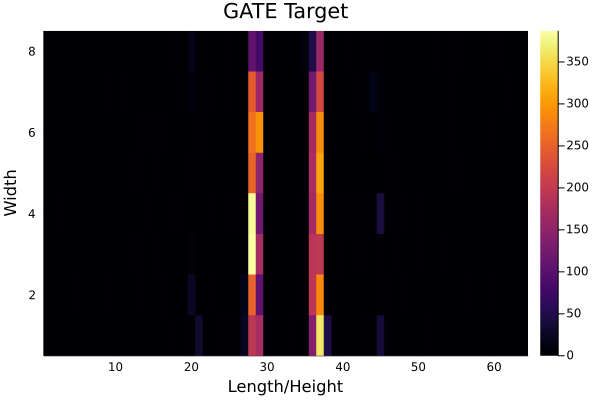

Training R2: 0.8021010508443178
Validation R2: 0.8466880115315196

	4

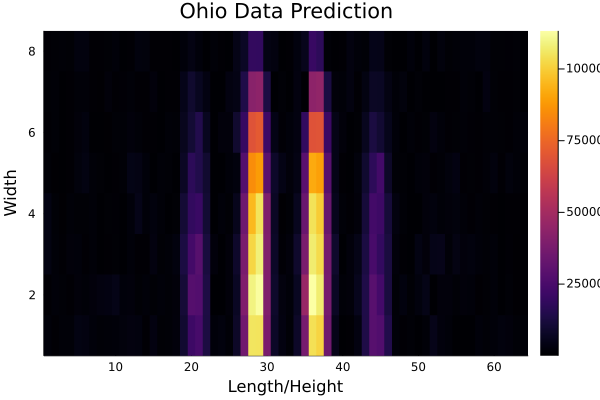

loss(trainingArray, targetArray) = 1330.6609f0
loss(trainingArray, targetArray) = 1317.059f0
loss(trainingArray, targetArray) = 1304.0829f0
loss(trainingArray, targetArray) = 1291.5294f0
loss(trainingArray, targetArray) = 1279.5408f0
loss(trainingArray, targetArray) = 1268.2017f0
loss(trainingArray, targetArray) = 1257.4639f0
loss(trainingArray, targetArray) = 1247.2976f0
loss(trainingArray, targetArray) = 1239.2987f0


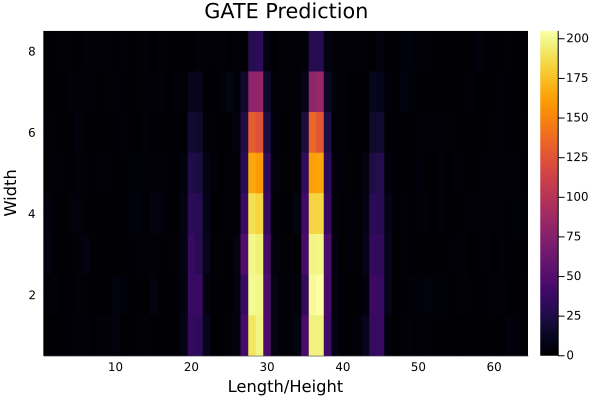

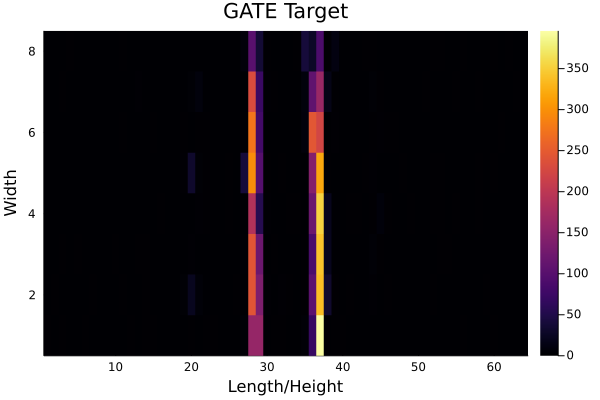

Training R2: 0.8181359846627759
Validation R2: 0.8613100394390332

	7

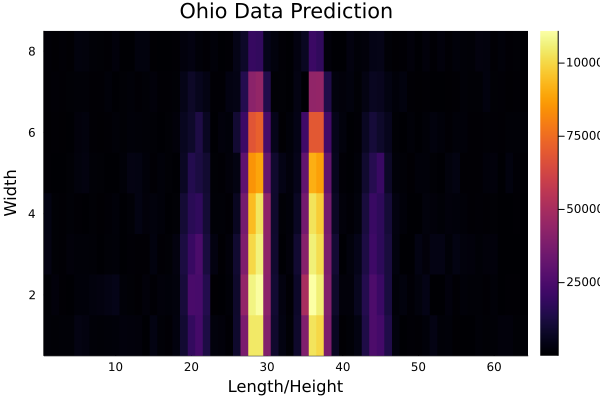

loss(trainingArray, targetArray) = 1234.7253f0
loss(trainingArray, targetArray) = 1227.4155f0
loss(trainingArray, targetArray) = 1219.1888f0
loss(trainingArray, targetArray) = 1211.4829f0
loss(trainingArray, targetArray) = 1204.4088f0
loss(trainingArray, targetArray) = 1197.7808f0
loss(trainingArray, targetArray) = 1191.6954f0
loss(trainingArray, targetArray) = 1186.2133f0
loss(trainingArray, targetArray) = 1181.0272f0


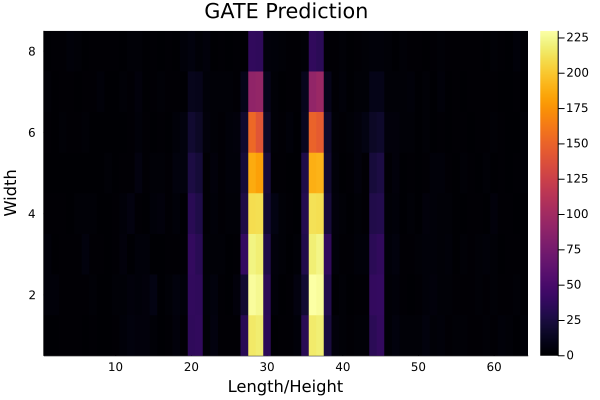

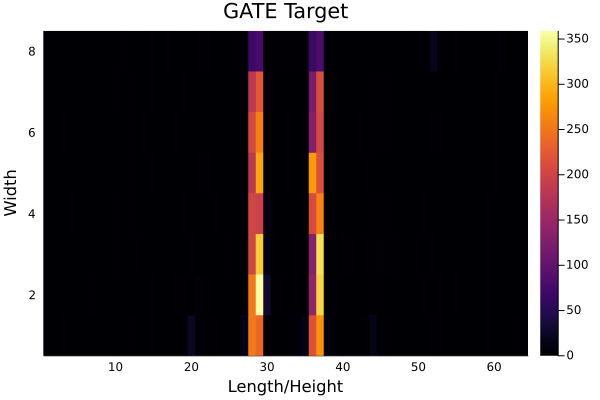

Training R2: 0.8290052360177982
Validation R2: 0.8715588818019819

	3

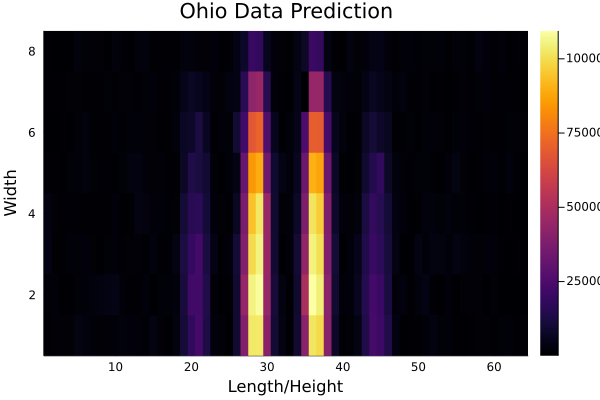

loss(trainingArray, targetArray) = 1178.6388f0
loss(trainingArray, targetArray) = 1174.8601f0
loss(trainingArray, targetArray) = 1170.7524f0
loss(trainingArray, targetArray) = 1166.9261f0
loss(trainingArray, targetArray) = 1163.3613f0
loss(trainingArray, targetArray) = 1160.1373f0
loss(trainingArray, targetArray) = 1157.1487f0
loss(trainingArray, targetArray) = 1154.4192f0
loss(trainingArray, targetArray) = 1151.8032f0


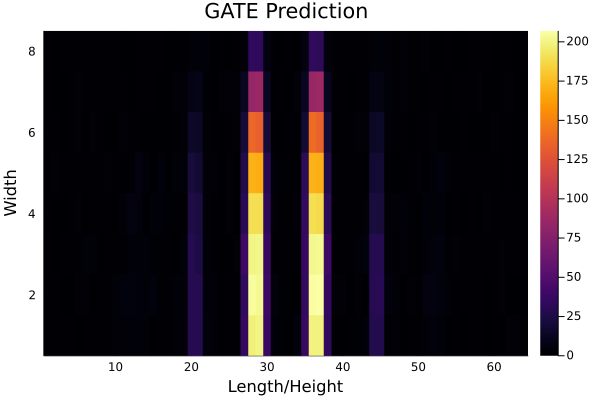

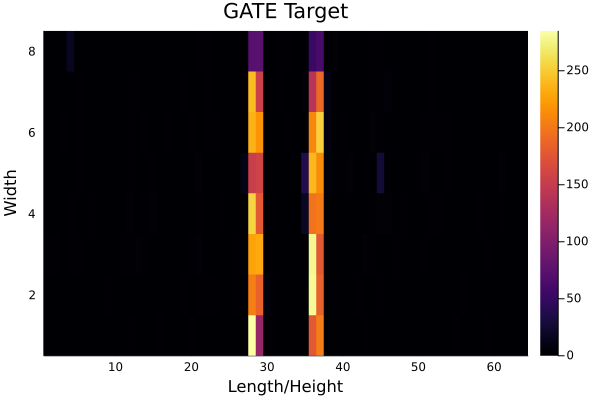

Training R2: 0.8366982007707653
Validation R2: 0.8788048707627444

	1

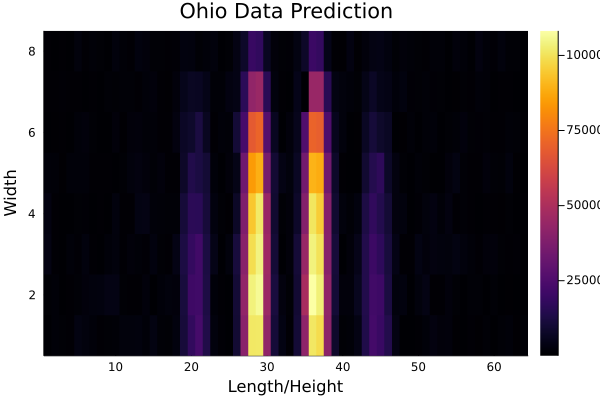

loss(trainingArray, targetArray) = 1150.6027f0
loss(trainingArray, targetArray) = 1148.6918f0
loss(trainingArray, targetArray) = 1146.5018f0
loss(trainingArray, targetArray) = 1144.4879f0
loss(trainingArray, targetArray) = 1142.5454f0
loss(trainingArray, targetArray) = 1140.6725f0
loss(trainingArray, targetArray) = 1138.9194f0
loss(trainingArray, targetArray) = 1137.2946f0
loss(trainingArray, targetArray) = 1135.7069f0


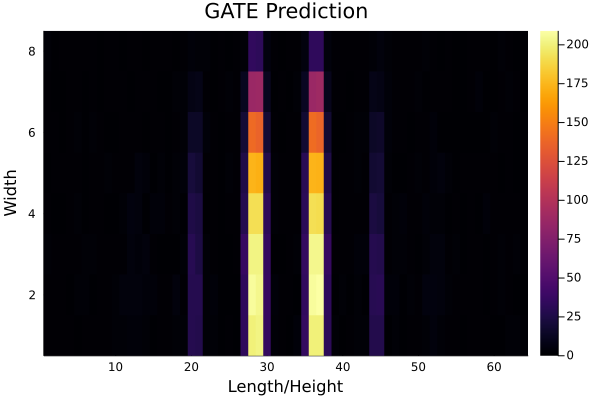

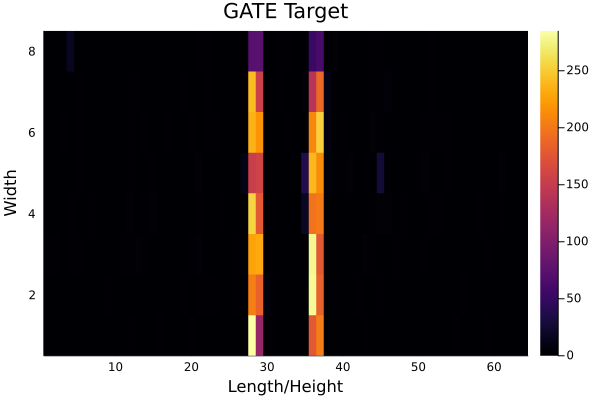

Training R2: 0.8424773120486727
Validation R2: 0.8840922501509981

	1

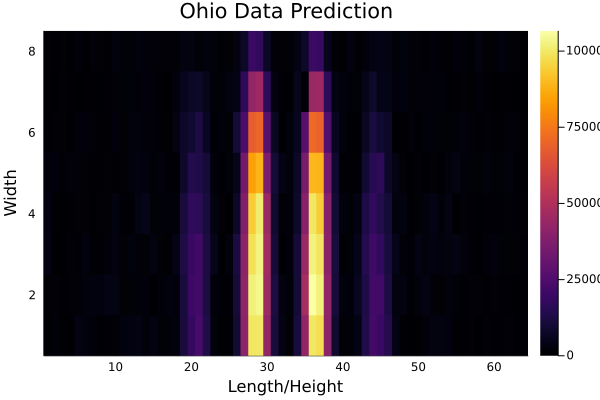

loss(trainingArray, targetArray) = 1134.9419f0
loss(trainingArray, targetArray) = 1133.6804f0
loss(trainingArray, targetArray) = 1132.1864f0
loss(trainingArray, targetArray) = 1130.8336f0
loss(trainingArray, targetArray) = 1129.4069f0
loss(trainingArray, targetArray) = 1128.0427f0
loss(trainingArray, targetArray) = 1126.6882f0
loss(trainingArray, targetArray) = 1125.4197f0
loss(trainingArray, targetArray) = 1124.0786f0


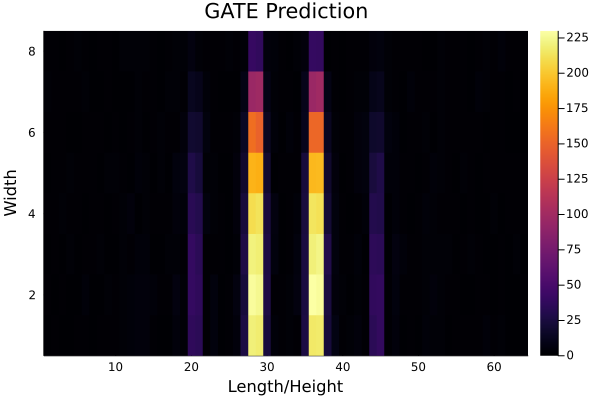

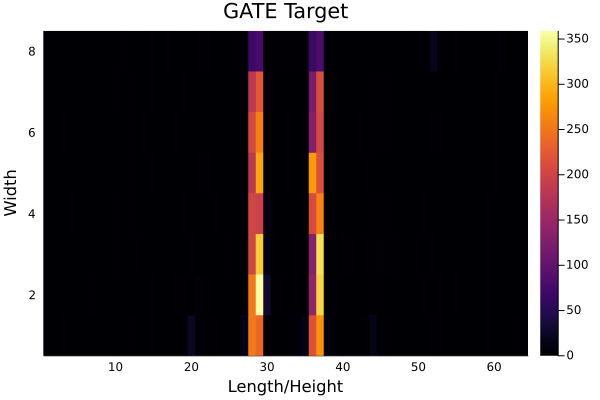

Training R2: 0.847846174799728
Validation R2: 0.8888229924090207

	3

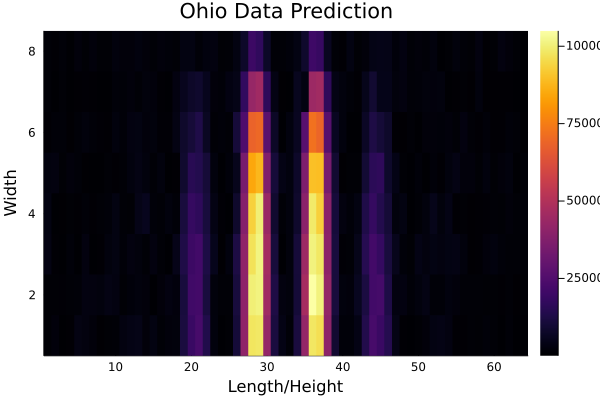

loss(trainingArray, targetArray) = 1123.4181f0
loss(trainingArray, targetArray) = 1122.2799f0
loss(trainingArray, targetArray) = 1120.8872f0
loss(trainingArray, targetArray) = 1119.4954f0
loss(trainingArray, targetArray) = 1118.0941f0
loss(trainingArray, targetArray) = 1116.5736f0
loss(trainingArray, targetArray) = 1115.1377f0
loss(trainingArray, targetArray) = 1113.761f0
loss(trainingArray, targetArray) = 1112.3154f0


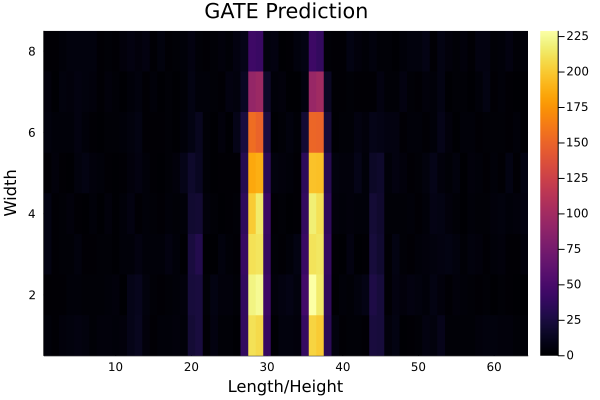

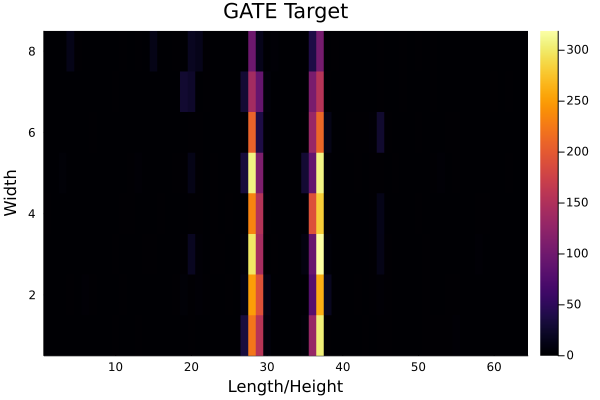

Training R2: 0.853301013823945
Validation R2: 0.8934009130155228

	8

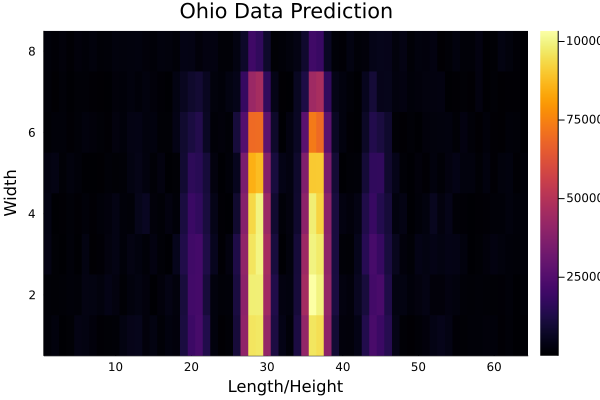

loss(trainingArray, targetArray) = 1111.5973f0
loss(trainingArray, targetArray) = 1110.5382f0
loss(trainingArray, targetArray) = 1109.2108f0
loss(trainingArray, targetArray) = 1107.8756f0
loss(trainingArray, targetArray) = 1106.6046f0
loss(trainingArray, targetArray) = 1105.3472f0
loss(trainingArray, targetArray) = 1104.0111f0
loss(trainingArray, targetArray) = 1102.8011f0
loss(trainingArray, targetArray) = 1101.5267f0


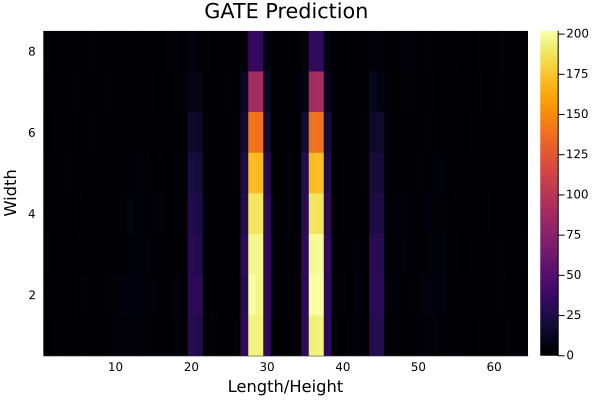

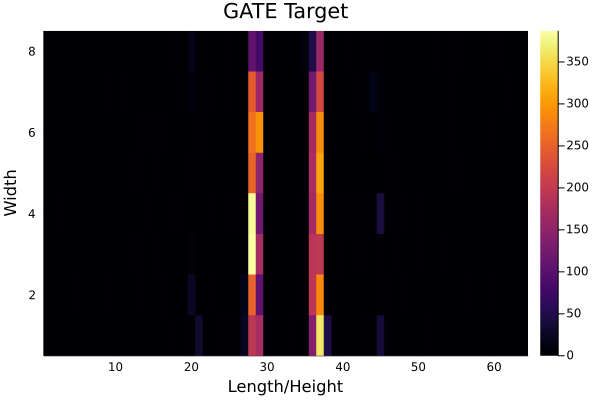

Training R2: 0.8595303710583099
Validation R2: 0.8981972184308339

	4

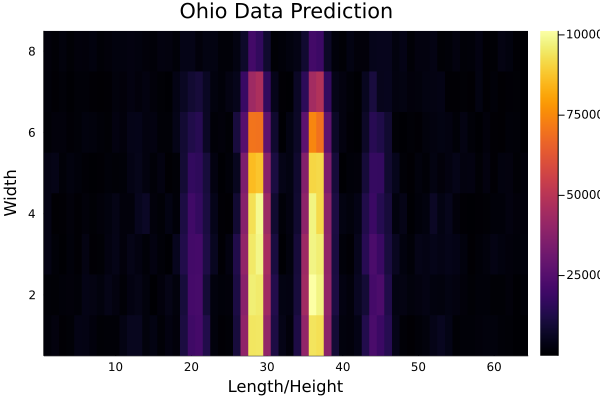

loss(trainingArray, targetArray) = 1100.8755f0
loss(trainingArray, targetArray) = 1099.8853f0
loss(trainingArray, targetArray) = 1098.6937f0
loss(trainingArray, targetArray) = 1097.4324f0
loss(trainingArray, targetArray) = 1096.2545f0
loss(trainingArray, targetArray) = 1095.1862f0
loss(trainingArray, targetArray) = 1093.8724f0
loss(trainingArray, targetArray) = 1092.7075f0
loss(trainingArray, targetArray) = 1091.5566f0


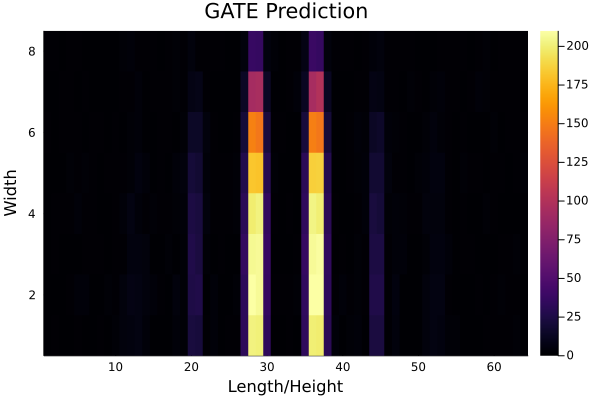

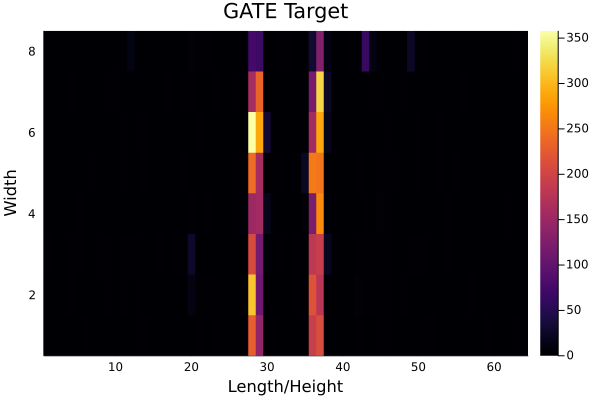

Training R2: 0.8663086496249837
Validation R2: 0.9028268588623647

	5

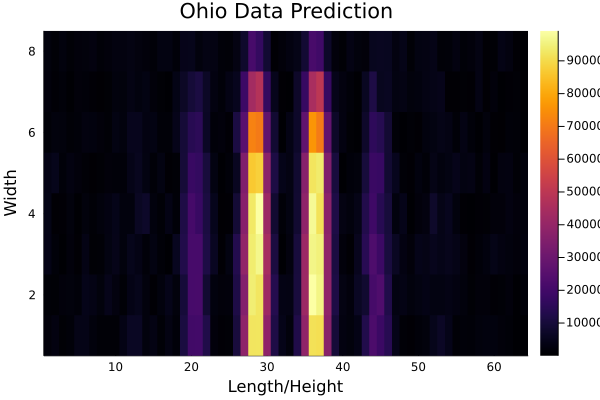

loss(trainingArray, targetArray) = 1090.9412f0
loss(trainingArray, targetArray) = 1090.0432f0
loss(trainingArray, targetArray) = 1088.8823f0
loss(trainingArray, targetArray) = 1087.7385f0
loss(trainingArray, targetArray) = 1086.5626f0
loss(trainingArray, targetArray) = 1085.4597f0
loss(trainingArray, targetArray) = 1084.3422f0
loss(trainingArray, targetArray) = 1083.2286f0
loss(trainingArray, targetArray) = 1082.1764f0


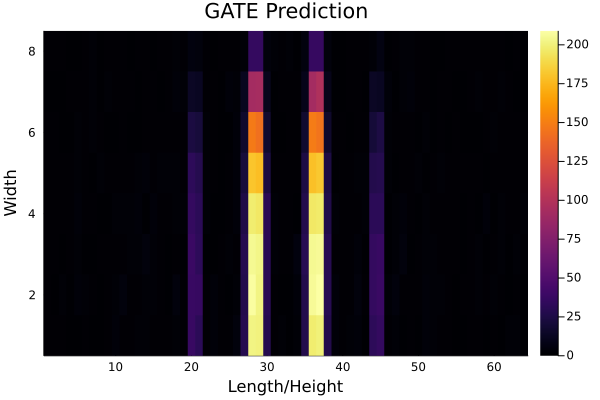

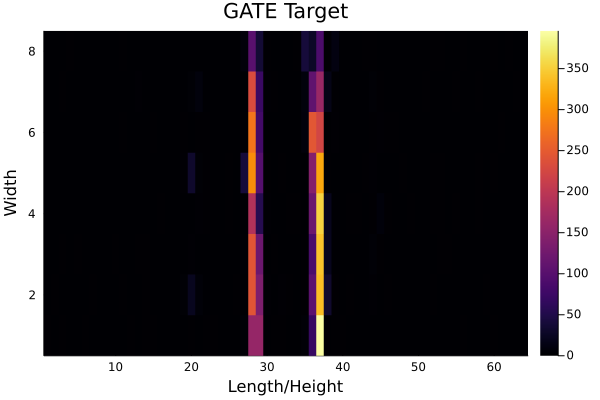

Training R2: 0.8736803421973401
Validation R2: 0.9075777915486727

	7

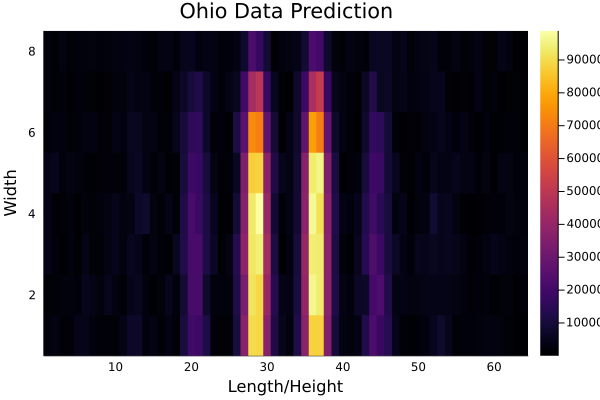

loss(trainingArray, targetArray) = 1081.602f0
loss(trainingArray, targetArray) = 1080.6539f0
loss(trainingArray, targetArray) = 1079.5554f0
loss(trainingArray, targetArray) = 1078.55f0
loss(trainingArray, targetArray) = 1077.4354f0
loss(trainingArray, targetArray) = 1076.3954f0
loss(trainingArray, targetArray) = 1075.4407f0
loss(trainingArray, targetArray) = 1074.3629f0
loss(trainingArray, targetArray) = 1073.3708f0


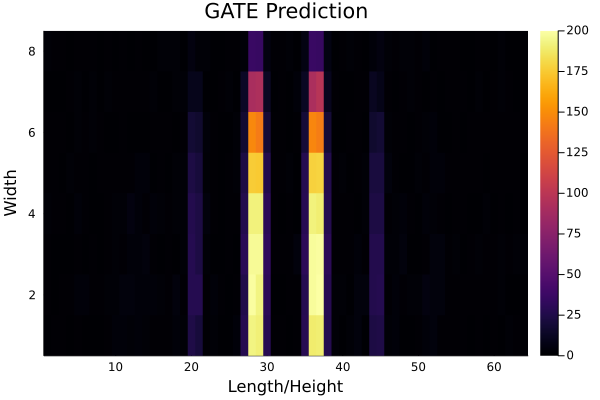

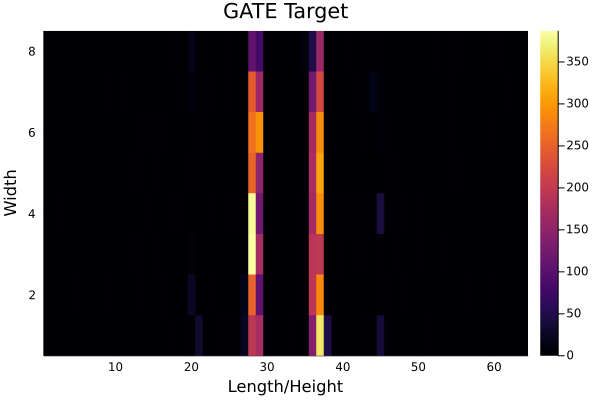

Training R2: 0.8810402987510418
Validation R2: 0.9121536583335592

	4

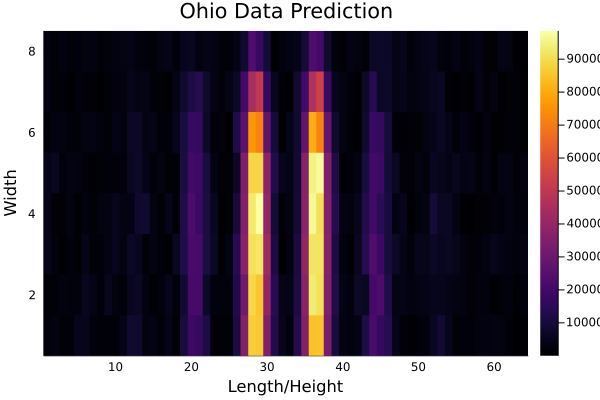

loss(trainingArray, targetArray) = 1072.8665f0
loss(trainingArray, targetArray) = 1072.0737f0
loss(trainingArray, targetArray) = 1071.1093f0
loss(trainingArray, targetArray) = 1070.0851f0
loss(trainingArray, targetArray) = 1069.1433f0
loss(trainingArray, targetArray) = 1068.1521f0
loss(trainingArray, targetArray) = 1067.224f0
loss(trainingArray, targetArray) = 1066.2723f0
loss(trainingArray, targetArray) = 1065.2805f0


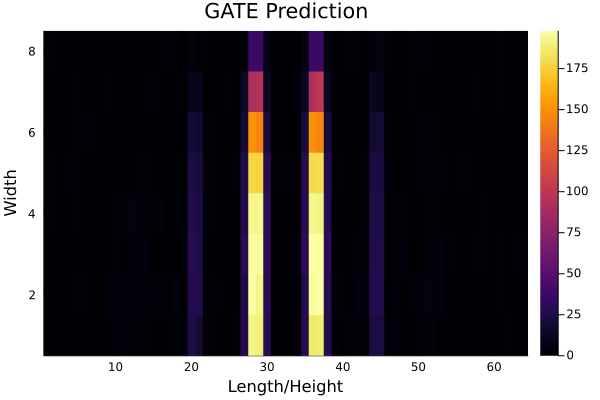

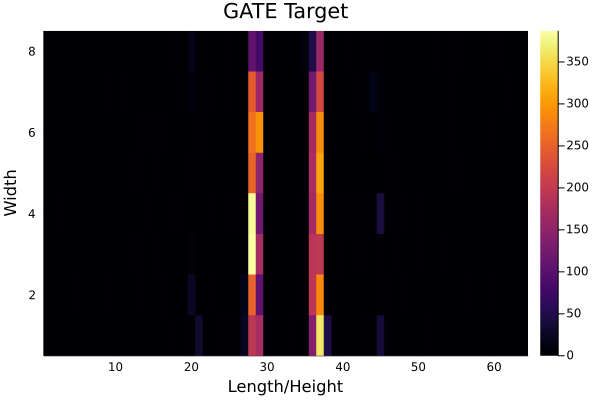

Training R2: 0.8882899923546682
Validation R2: 0.9167633276978209

	4

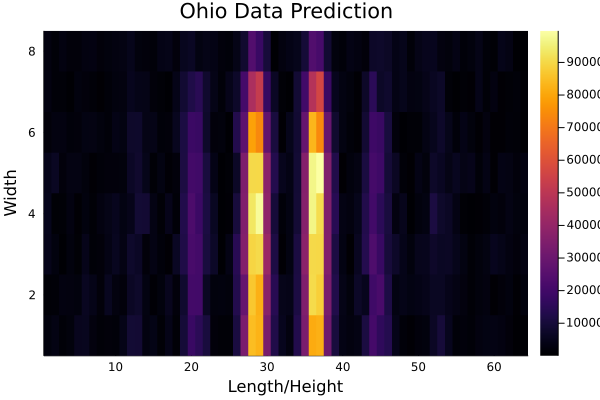

loss(trainingArray, targetArray) = 1064.8796f0
loss(trainingArray, targetArray) = 1064.1624f0
loss(trainingArray, targetArray) = 1063.155f0
loss(trainingArray, targetArray) = 1062.2959f0
loss(trainingArray, targetArray) = 1061.4688f0
loss(trainingArray, targetArray) = 1060.5449f0
loss(trainingArray, targetArray) = 1059.7822f0
loss(trainingArray, targetArray) = 1058.874f0
loss(trainingArray, targetArray) = 1057.9996f0


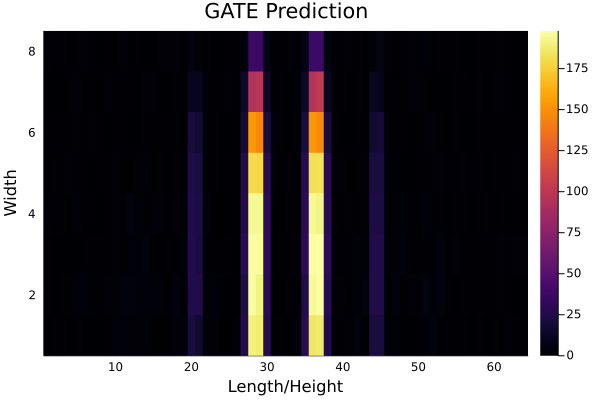

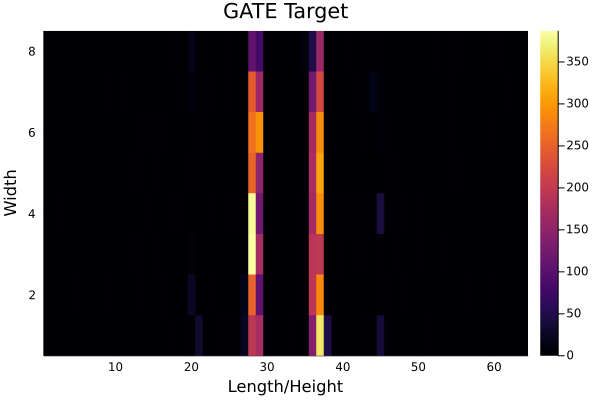

Training R2: 0.8947635588091789
Validation R2: 0.9208600559319335

	4

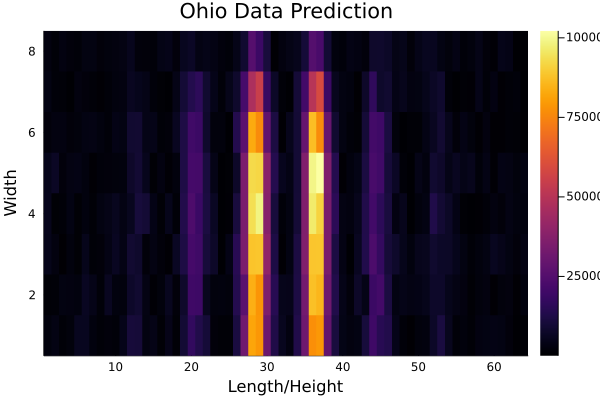

loss(trainingArray, targetArray) = 1057.6383f0
loss(trainingArray, targetArray) = 1057.0111f0
loss(trainingArray, targetArray) = 1056.1118f0
loss(trainingArray, targetArray) = 1055.3651f0
loss(trainingArray, targetArray) = 1054.532f0
loss(trainingArray, targetArray) = 1053.7506f0
loss(trainingArray, targetArray) = 1053.0071f0
loss(trainingArray, targetArray) = 1052.1881f0
loss(trainingArray, targetArray) = 1051.443f0


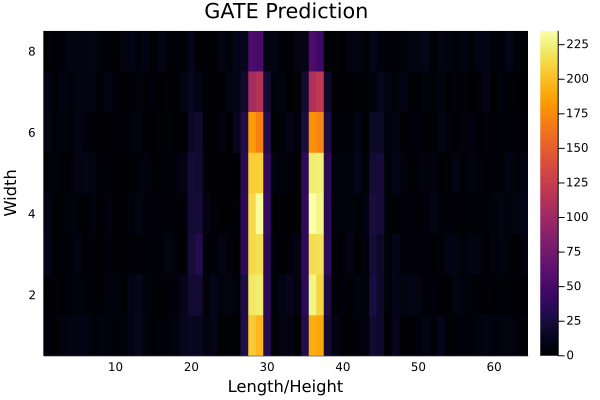

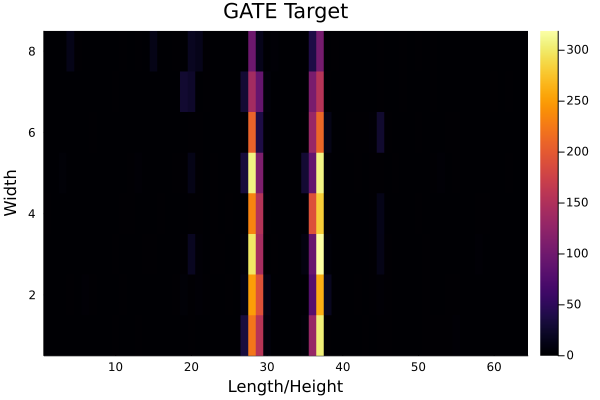

Training R2: 0.9003313702351908
Validation R2: 0.9245060648702045

	8

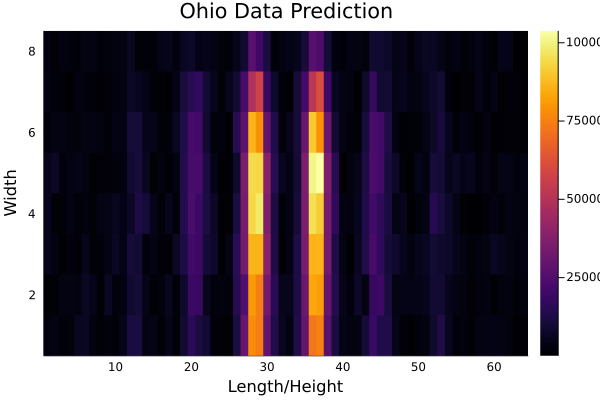

loss(trainingArray, targetArray) = 1050.9958f0
loss(trainingArray, targetArray) = 1050.3868f0
loss(trainingArray, targetArray) = 1049.6595f0
loss(trainingArray, targetArray) = 1048.8568f0
loss(trainingArray, targetArray) = 1048.1368f0
loss(trainingArray, targetArray) = 1047.3688f0
loss(trainingArray, targetArray) = 1046.6605f0
loss(trainingArray, targetArray) = 1045.9579f0
loss(trainingArray, targetArray) = 1045.2614f0


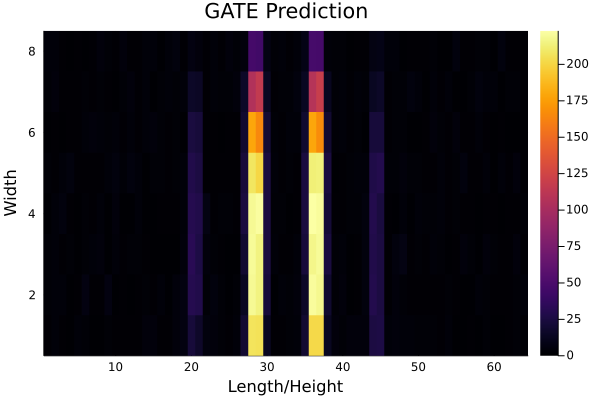

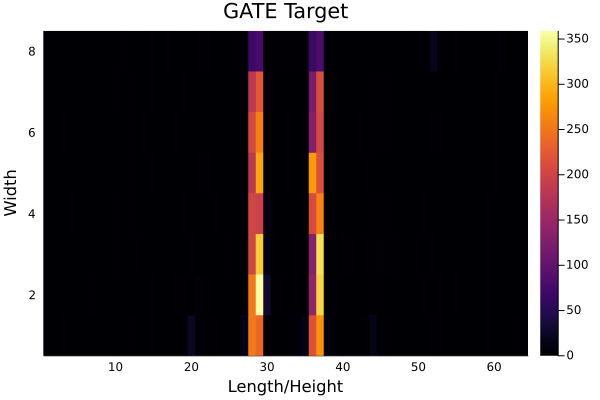

Training R2: 0.9050466401046456
Validation R2: 0.9280868376578701

	3

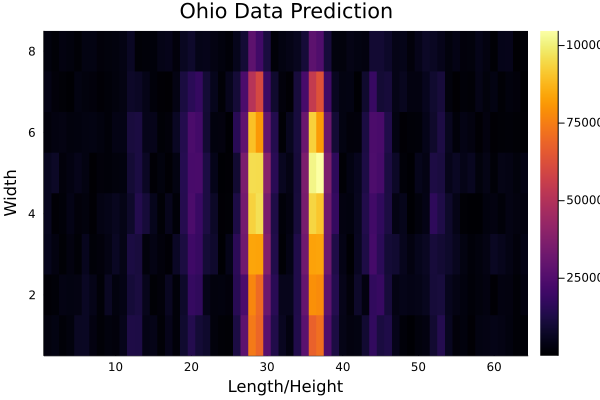

loss(trainingArray, targetArray) = 1044.8561f0
loss(trainingArray, targetArray) = 1044.2526f0
loss(trainingArray, targetArray) = 1043.5721f0
loss(trainingArray, targetArray) = 1042.9467f0
loss(trainingArray, targetArray) = 1042.1371f0
loss(trainingArray, targetArray) = 1041.4135f0
loss(trainingArray, targetArray) = 1040.5388f0
loss(trainingArray, targetArray) = 1039.8263f0
loss(trainingArray, targetArray) = 1038.786f0


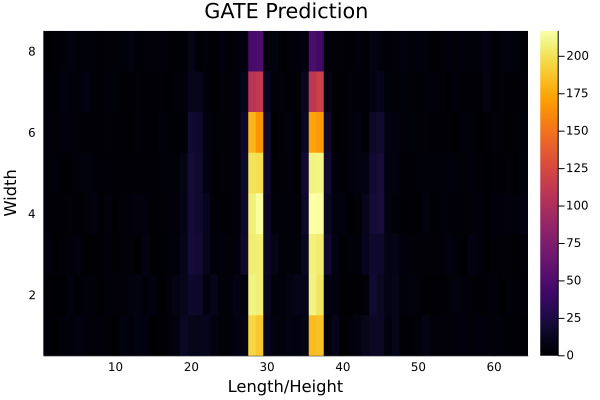

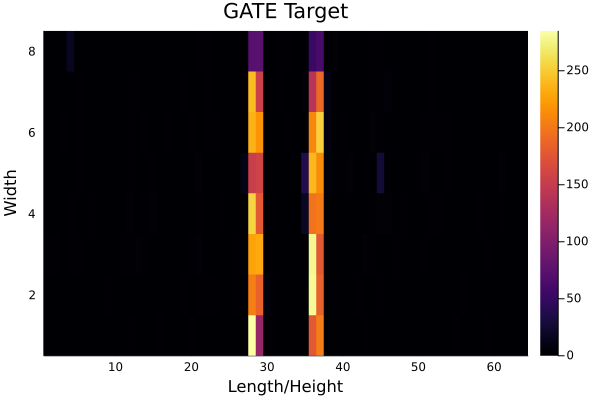

Training R2: 0.9097678150934948
Validation R2: 0.9310835150382701

	1

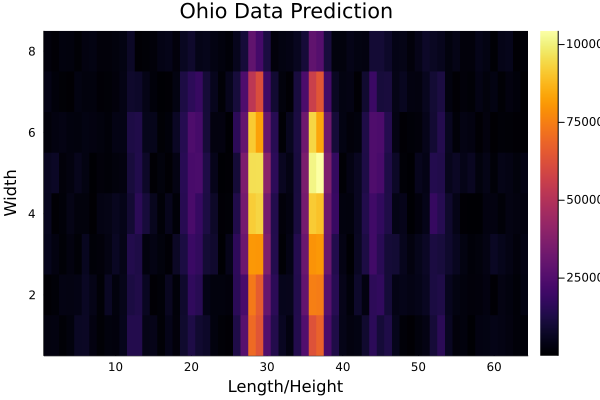

loss(trainingArray, targetArray) = 1038.246f0
loss(trainingArray, targetArray) = 1037.4662f0
loss(trainingArray, targetArray) = 1036.564f0
loss(trainingArray, targetArray) = 1035.6357f0
loss(trainingArray, targetArray) = 1034.7587f0
loss(trainingArray, targetArray) = 1033.7466f0
loss(trainingArray, targetArray) = 1032.9769f0
loss(trainingArray, targetArray) = 1031.8303f0
loss(trainingArray, targetArray) = 1030.8115f0


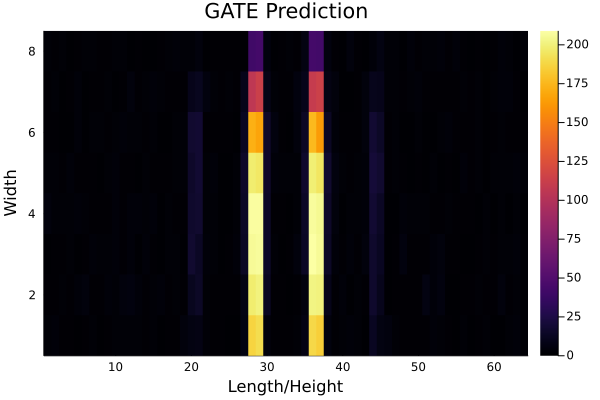

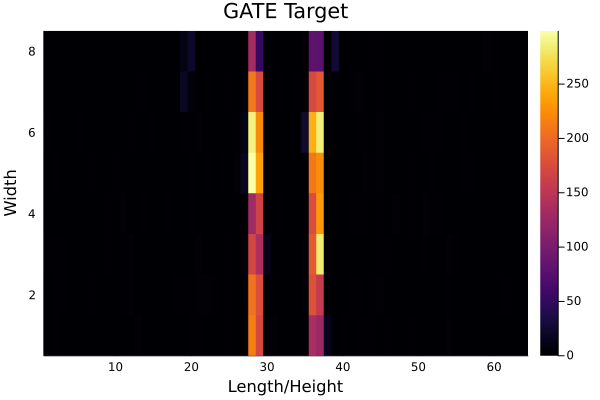

Training R2: 0.9257217976645918
Validation R2: 0.9368741334441336

	2

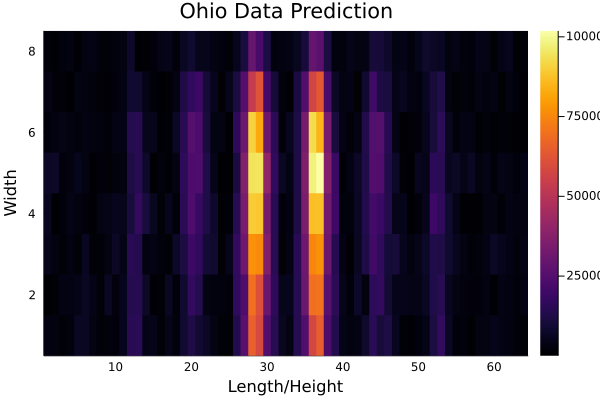

loss(trainingArray, targetArray) = 1030.2728f0
loss(trainingArray, targetArray) = 1029.1885f0
loss(trainingArray, targetArray) = 1027.5955f0
loss(trainingArray, targetArray) = 1025.8599f0
loss(trainingArray, targetArray) = 1024.0269f0
loss(trainingArray, targetArray) = 1022.36633f0
loss(trainingArray, targetArray) = 1021.9984f0
loss(trainingArray, targetArray) = 1023.9636f0
loss(trainingArray, targetArray) = 1021.3899f0


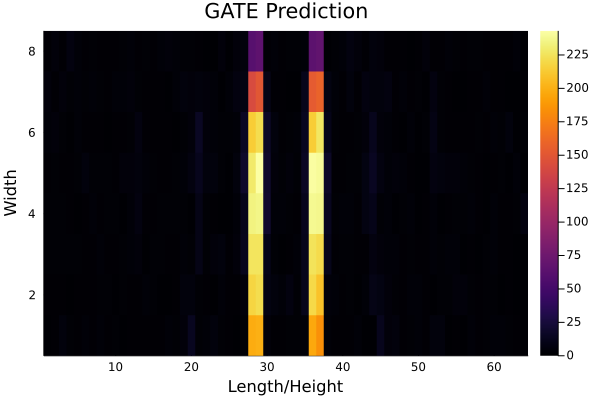

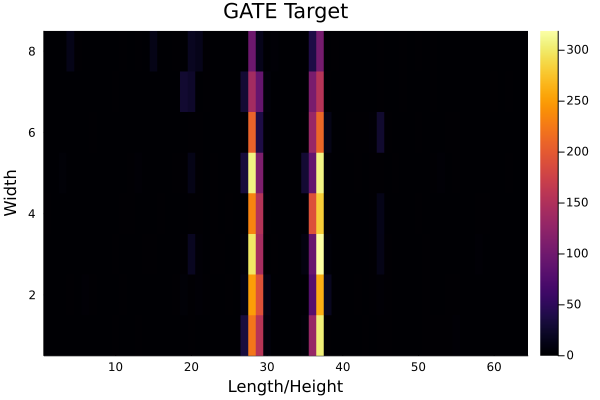

Training R2: 0.9226696104567191
Validation R2: 0.94026875402547

	8

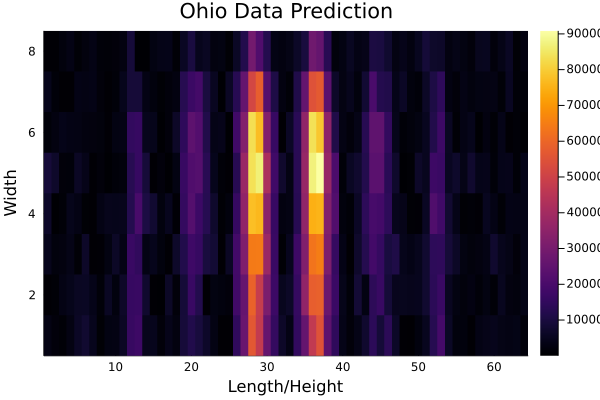

loss(trainingArray, targetArray) = 1021.0807f0
loss(trainingArray, targetArray) = 1018.8153f0
loss(trainingArray, targetArray) = 1017.04626f0
loss(trainingArray, targetArray) = 1015.751f0
loss(trainingArray, targetArray) = 1014.73865f0
loss(trainingArray, targetArray) = 1013.9796f0
loss(trainingArray, targetArray) = 1014.03705f0
loss(trainingArray, targetArray) = 1012.36676f0
loss(trainingArray, targetArray) = 1011.2652f0


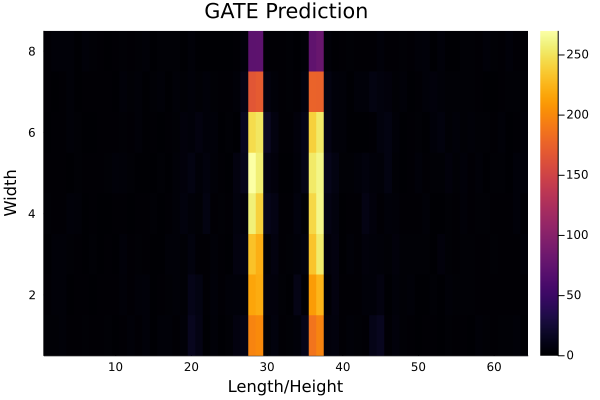

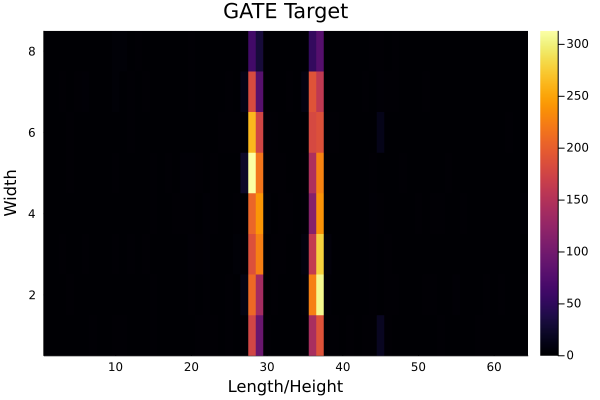

Training R2: 0.9380530391539631
Validation R2: 0.9358868356231939

	6

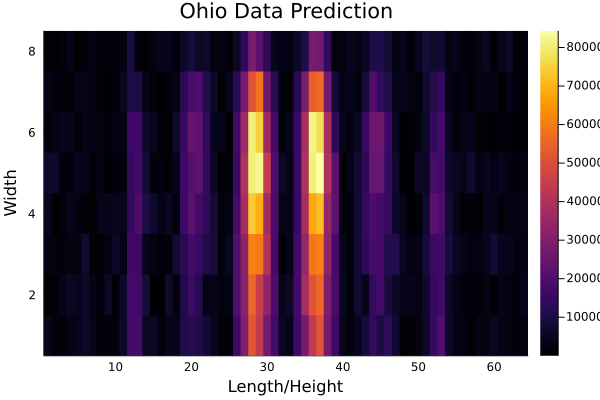

In [34]:
while i <= 20 && CVR2 < CurrentVR2
    CVR2 = CurrentVR2
    Flux.train!(loss, params(m), dataset, opt, cb = throttle(evalcb, 5))
    CurrentR2 = r2(lm(@formula(A  ~ B), DataFrame(A=Float64.(m(trainingArray)[:,1]), B=targetArray[:,1])))
    print("Training R2: ", CurrentR2, '\n')
    CurrentVR2 = r2(lm(@formula(A  ~ B), DataFrame(A=Float64.(m(validationArray)[:,1]), B=validationTargetArray[:,1])))
    print("Validation R2: ", CurrentVR2, '\n')
    print("\n\t")
    plotResults(m)
end

In [35]:
function writeOutput(m)
    readPath = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    readArray = filter(x->occursin(string("A000"), x), readdir(readPath))
    readSize = size(readArray)[1]
    
    path = "/home/jupyter-nrmeskell/dosimeter/neural_nets/JuliaOutputs/OptimizedRuns"
    runNumber = lpad(size(readdir(path))[1], 3, "0")
    path = string(path, "/Run", runNumber, "R2-", lpad(Int(round(CurrentVR2, digits=3)*1000),3,"0"))
    mkdir(path)
    mkdir(string(path, "/fullSimulationOutputs"))
    mkdir(string(path, "/fullOhioOutputs"))
            
    for i = 1:size(validationTargetArray)[2]
        beamSize = filter(x->occursin(string("A000"), x), readdir(readPath))[div(i+2,3)][1:13]

        writedlm(string(path,"/fullSimulationOutputs/ValidationTarget",lpad(i,3,"0"), "-", beamSize, ".txt"), reshape(validationTargetArray[:,i], (8*8,8)), " ")
        writedlm(string(path,"/fullSimulationOutputs/ValidationOutput",lpad(i,3,"0"), "-", beamSize, ".txt"), reshape(m(validationArray)[:,i], (8*8,8)), " ")
    end


    readPath = "/home/jupyter-nrmeskell/dosimeter/gate_data/bars/"
    readArray = filter(x->occursin(string("A000"), x), readdir(readPath))
    for i = 1:size(inputArray)[4]
        writedlm(string(path,"/fullOhioOutputs/OhioOutput",lpad(i,3,"0"),".txt"), Int.(round.(reshape(m(inputArray)[:,i], (8*8,8)))), " ")
    end
end

writeOutput (generic function with 1 method)

In [ ]:
writeOutput(m)